In [1]:
## Reading libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import KFold,StratifiedKFold

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('max_column', 100)

In [2]:
def negative(x):
    if x < 0.0:
        return 0
    else:
        return x

In [3]:
sample_sub = pd.read_csv('SampleSubmission.csv')
train = pd.read_csv('Train.csv')

In [4]:
train.head(2)

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,precip 2014-12-28 - 2015-01-04,precip 2015-01-04 - 2015-01-11,precip 2015-01-11 - 2015-01-18,precip 2015-01-18 - 2015-01-25,precip 2015-01-25 - 2015-02-01,precip 2015-02-01 - 2015-02-08,precip 2015-02-08 - 2015-02-15,precip 2015-02-15 - 2015-02-22,precip 2015-02-22 - 2015-03-01,precip 2015-03-01 - 2015-03-08,precip 2015-03-08 - 2015-03-15,precip 2019-01-20 - 2019-01-27,precip 2019-01-27 - 2019-02-03,precip 2019-02-03 - 2019-02-10,precip 2019-02-10 - 2019-02-17,precip 2019-02-17 - 2019-02-24,precip 2019-02-24 - 2019-03-03,precip 2019-03-03 - 2019-03-10,precip 2019-03-10 - 2019-03-17,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,57.451361,30.127047,30.449468,1.521829,29.389995,32.878318,8.179804,0.963981,16.659097,3.304466,0.0,12.99262,4.582856,35.037532,4.796012,28.083314,0.0,58.362456,18.264692,17.537486,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41


In [5]:
# Creating lists of columns to be used in separating the dataframe into training and testing datasets
# Using a for loop for efficiency
#
precip_features_2019 = []
precip_features_2015 = []
for col in train.columns:
  if '2019' in col:
    precip_features_2019.append(col)
  elif 'precip 2014' in col:
    precip_features_2015.append(col)
  elif 'precip 2015' in col:
    precip_features_2015.append(col)
new_train = train[train.columns.difference(precip_features_2019)]
# Separating the test dataset from the main dataframe
precip_features_2019.extend(['X', 'Y', 'elevation', 'LC_Type1_mode', 'Square_ID'])
test = train[precip_features_2019]
# Creating a dictionary of column names to be renamed for the training dataset
# The column names are renamed for conveniency
#
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):
  if 'precip' in col:
    new_2015_cols[col] = 'week_' + str(number) + '_precip'

    
# Creating a dictionary of column names to be renamed for the testing dataset
#
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
  if 'precip' in col:
    new_2019_cols[col] = 'week_' + str(number) + '_precip'
    
# Renaming the columns
#
new_train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)
# Separating the target variable
#
target = new_train.target_2015


# Aligning the training and testing datasets
#
new_train, test = new_train.align(test, join = 'inner', axis = 1)
test_id = sample_sub['Square_ID']
y = target
new_train.drop(columns='Square_ID', inplace=True)
test.drop(columns='Square_ID', inplace=True)
X = new_train

In [6]:
X_len = len(X)
new_df = pd.concat([X, test])

In [7]:
#Manhattan distnace
def manhattan_distance(lat, lon):
    a = np.abs(lat -lon)
    return a
new_df['manhattan_dist'] = manhattan_distance(new_df['X'].values, new_df['Y'].values,)
new_df.head()

#Bearing
def bearing_array(lat, lng):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lat - lng)
    lat, lng = map(np.radians, (lat, lng))
    y = np.sin(lng_delta_rad) * np.cos(lat)
    x = np.cos(lat) * np.sin(lat) - np.sin(lng) * np.cos(lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
new_df['bearing'] = bearing_array(new_df['X'].values, new_df['Y'].values,)
new_df.head()
corr_matrix = new_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.7)]
print('There are {} columns with >= 0.7 correlation'.format(len(to_drop)))
to_drop

There are 10 columns with >= 0.7 correlation


['week_3_precip',
 'week_5_precip',
 'week_7_precip',
 'week_8_precip',
 'week_11_precip',
 'week_12_precip',
 'week_15_precip',
 'week_16_precip',
 'week_17_precip',
 'bearing']

In [8]:
new_df.drop(to_drop, axis=1, inplace=True)
train = new_df[:X_len]
test = new_df[X_len:]

In [9]:
train['target_2015'] = y

In [10]:
train['week_1_2_precip'] = train['week_2_precip'] * train['week_1_precip']
test['week_1_2_precip'] = test['week_2_precip'] * test['week_1_precip']

train['week_9_14_precip'] = train['week_9_precip'] * train['week_14_precip']
test['week_9_14_precip'] = test['week_9_precip'] * test['week_14_precip']

train.manhattan_dist = train.manhattan_dist  - train.Y
test.manhattan_dist = test.manhattan_dist  - train.Y

In [11]:
train['elevation'] = np.log(train['elevation'])
test['elevation'] = np.log(test['elevation'])

train['X'] = np.log(train['X'])
test['X'] = np.log(test['X'])

In [12]:
X = train.drop(columns='target_2015')

In [13]:
x_fold = X[:12006]
y_fold = y[:12006]

In [14]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]; categorical_features_indices

array([0])

## MODEL

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_fold, y_fold, test_size=0.2, random_state=1994)

In [16]:
model = CatBoostRegressor(learning_rate=0.09, max_depth=3, n_estimators=1000)
model.fit(X_train, y_train)

0:	learn: 0.2009505	total: 52.9ms	remaining: 52.8s
1:	learn: 0.1913255	total: 55.5ms	remaining: 27.7s
2:	learn: 0.1827345	total: 57.9ms	remaining: 19.2s
3:	learn: 0.1741279	total: 59.9ms	remaining: 14.9s
4:	learn: 0.1664655	total: 61.9ms	remaining: 12.3s
5:	learn: 0.1598194	total: 63.8ms	remaining: 10.6s
6:	learn: 0.1535373	total: 65.7ms	remaining: 9.32s
7:	learn: 0.1482400	total: 67.6ms	remaining: 8.38s
8:	learn: 0.1433914	total: 69.4ms	remaining: 7.64s
9:	learn: 0.1393149	total: 71.3ms	remaining: 7.06s
10:	learn: 0.1360431	total: 73.1ms	remaining: 6.58s
11:	learn: 0.1329396	total: 75ms	remaining: 6.17s
12:	learn: 0.1305291	total: 76.8ms	remaining: 5.83s
13:	learn: 0.1280291	total: 78.6ms	remaining: 5.54s
14:	learn: 0.1259794	total: 80.8ms	remaining: 5.31s
15:	learn: 0.1239153	total: 84.3ms	remaining: 5.18s
16:	learn: 0.1222439	total: 86.3ms	remaining: 4.99s
17:	learn: 0.1205548	total: 88.1ms	remaining: 4.81s
18:	learn: 0.1195815	total: 89.9ms	remaining: 4.64s
19:	learn: 0.1183673	tot

179:	learn: 0.0869826	total: 431ms	remaining: 1.96s
180:	learn: 0.0868815	total: 437ms	remaining: 1.98s
181:	learn: 0.0868266	total: 440ms	remaining: 1.98s
182:	learn: 0.0867723	total: 443ms	remaining: 1.98s
183:	learn: 0.0867436	total: 446ms	remaining: 1.98s
184:	learn: 0.0866949	total: 448ms	remaining: 1.98s
185:	learn: 0.0866076	total: 451ms	remaining: 1.97s
186:	learn: 0.0865586	total: 454ms	remaining: 1.97s
187:	learn: 0.0865142	total: 457ms	remaining: 1.97s
188:	learn: 0.0863918	total: 459ms	remaining: 1.97s
189:	learn: 0.0863328	total: 462ms	remaining: 1.97s
190:	learn: 0.0862912	total: 465ms	remaining: 1.97s
191:	learn: 0.0861717	total: 467ms	remaining: 1.97s
192:	learn: 0.0861294	total: 470ms	remaining: 1.96s
193:	learn: 0.0861062	total: 472ms	remaining: 1.96s
194:	learn: 0.0860809	total: 475ms	remaining: 1.96s
195:	learn: 0.0860677	total: 478ms	remaining: 1.96s
196:	learn: 0.0860276	total: 480ms	remaining: 1.96s
197:	learn: 0.0859492	total: 489ms	remaining: 1.98s
198:	learn: 

340:	learn: 0.0810040	total: 812ms	remaining: 1.57s
341:	learn: 0.0809756	total: 819ms	remaining: 1.58s
342:	learn: 0.0809354	total: 822ms	remaining: 1.57s
343:	learn: 0.0809131	total: 825ms	remaining: 1.57s
344:	learn: 0.0808955	total: 828ms	remaining: 1.57s
345:	learn: 0.0808877	total: 830ms	remaining: 1.57s
346:	learn: 0.0808671	total: 833ms	remaining: 1.57s
347:	learn: 0.0808368	total: 836ms	remaining: 1.56s
348:	learn: 0.0808199	total: 840ms	remaining: 1.57s
349:	learn: 0.0807641	total: 846ms	remaining: 1.57s
350:	learn: 0.0807531	total: 848ms	remaining: 1.57s
351:	learn: 0.0807051	total: 850ms	remaining: 1.56s
352:	learn: 0.0806845	total: 852ms	remaining: 1.56s
353:	learn: 0.0806290	total: 854ms	remaining: 1.56s
354:	learn: 0.0806170	total: 856ms	remaining: 1.55s
355:	learn: 0.0805836	total: 858ms	remaining: 1.55s
356:	learn: 0.0805635	total: 860ms	remaining: 1.55s
357:	learn: 0.0805392	total: 862ms	remaining: 1.54s
358:	learn: 0.0805097	total: 863ms	remaining: 1.54s
359:	learn: 

513:	learn: 0.0765119	total: 1.19s	remaining: 1.13s
514:	learn: 0.0765073	total: 1.2s	remaining: 1.13s
515:	learn: 0.0764864	total: 1.2s	remaining: 1.12s
516:	learn: 0.0764774	total: 1.2s	remaining: 1.12s
517:	learn: 0.0764255	total: 1.21s	remaining: 1.12s
518:	learn: 0.0764174	total: 1.21s	remaining: 1.12s
519:	learn: 0.0763467	total: 1.21s	remaining: 1.12s
520:	learn: 0.0763183	total: 1.22s	remaining: 1.12s
521:	learn: 0.0762977	total: 1.22s	remaining: 1.12s
522:	learn: 0.0762563	total: 1.22s	remaining: 1.11s
523:	learn: 0.0762309	total: 1.23s	remaining: 1.11s
524:	learn: 0.0761682	total: 1.23s	remaining: 1.11s
525:	learn: 0.0761631	total: 1.23s	remaining: 1.11s
526:	learn: 0.0761337	total: 1.23s	remaining: 1.1s
527:	learn: 0.0761214	total: 1.23s	remaining: 1.1s
528:	learn: 0.0761158	total: 1.23s	remaining: 1.1s
529:	learn: 0.0761020	total: 1.24s	remaining: 1.1s
530:	learn: 0.0760955	total: 1.24s	remaining: 1.09s
531:	learn: 0.0760671	total: 1.24s	remaining: 1.09s
532:	learn: 0.07601

673:	learn: 0.0739633	total: 1.78s	remaining: 860ms
674:	learn: 0.0739534	total: 1.79s	remaining: 864ms
675:	learn: 0.0739408	total: 1.8s	remaining: 861ms
676:	learn: 0.0739247	total: 1.8s	remaining: 859ms
677:	learn: 0.0739133	total: 1.81s	remaining: 858ms
678:	learn: 0.0739020	total: 1.81s	remaining: 855ms
679:	learn: 0.0738878	total: 1.81s	remaining: 853ms
680:	learn: 0.0738724	total: 1.82s	remaining: 851ms
681:	learn: 0.0738649	total: 1.82s	remaining: 850ms
682:	learn: 0.0738573	total: 1.82s	remaining: 847ms
683:	learn: 0.0738142	total: 1.83s	remaining: 844ms
684:	learn: 0.0738074	total: 1.83s	remaining: 841ms
685:	learn: 0.0737774	total: 1.83s	remaining: 839ms
686:	learn: 0.0737702	total: 1.83s	remaining: 836ms
687:	learn: 0.0737600	total: 1.84s	remaining: 834ms
688:	learn: 0.0737413	total: 1.84s	remaining: 831ms
689:	learn: 0.0737395	total: 1.84s	remaining: 828ms
690:	learn: 0.0737176	total: 1.84s	remaining: 825ms
691:	learn: 0.0736963	total: 1.84s	remaining: 822ms
692:	learn: 0.

918:	learn: 0.0709826	total: 2.35s	remaining: 207ms
919:	learn: 0.0709658	total: 2.35s	remaining: 205ms
920:	learn: 0.0709633	total: 2.36s	remaining: 202ms
921:	learn: 0.0709503	total: 2.36s	remaining: 200ms
922:	learn: 0.0709399	total: 2.36s	remaining: 197ms
923:	learn: 0.0709186	total: 2.37s	remaining: 195ms
924:	learn: 0.0709066	total: 2.37s	remaining: 192ms
925:	learn: 0.0709004	total: 2.37s	remaining: 190ms
926:	learn: 0.0708981	total: 2.38s	remaining: 187ms
927:	learn: 0.0708888	total: 2.38s	remaining: 185ms
928:	learn: 0.0708799	total: 2.38s	remaining: 182ms
929:	learn: 0.0708654	total: 2.38s	remaining: 180ms
930:	learn: 0.0708344	total: 2.39s	remaining: 177ms
931:	learn: 0.0708308	total: 2.39s	remaining: 174ms
932:	learn: 0.0708252	total: 2.39s	remaining: 172ms
933:	learn: 0.0708113	total: 2.4s	remaining: 169ms
934:	learn: 0.0707910	total: 2.4s	remaining: 167ms
935:	learn: 0.0707890	total: 2.4s	remaining: 164ms
936:	learn: 0.0707762	total: 2.4s	remaining: 162ms
937:	learn: 0.07

In [17]:
predictions = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,predictions)))

0.07698272514985023


In [18]:
predic = model.predict(test)
d = {"Square_ID": test_id, 'target_2019': predic}
test_prediction = pd.DataFrame(data=d)
test_prediction = test_prediction[["Square_ID", 'target_2019']]

In [20]:
test_prediction['target_2019'] = test_prediction['target_2019'].map(negative)
test_prediction.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.000000
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.000000
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.033079
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.020674
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.020674


In [22]:
new_pred = np.where(train.target_2015 == 0, 0,test_prediction['target_2019'])
submission_df = pd.DataFrame({'Square_ID': test_id, 'target_2019': new_pred})

In [24]:
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
fold=KFold(n_splits=15, random_state=1234)

for train_index, test_index in fold.split(x_fold,y_fold):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m2=CatBoostRegressor(iterations=1200, learning_rate=0.2, depth=4, random_seed=1234, eval_metric='RMSE')
    m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=100,verbose=100,)
    preds=m2.predict(X_test)
    print("err: ",np.sqrt(mean_squared_error(y_test,preds)))
    errcb2.append(np.sqrt(mean_squared_error(y_test,preds)))
    p2 = m2.predict(test)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.1881910	test: 0.1881910	test1: 0.1234659	best: 0.1234659 (0)	total: 6.45ms	remaining: 7.73s
100:	learn: 0.0757061	test: 0.0757061	test1: 0.1212226	best: 0.1195222 (7)	total: 289ms	remaining: 3.15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1195221999
bestIteration = 7

Shrink model to first 8 iterations.
err:  0.1195221997856384
0:	learn: 0.1905528	test: 0.1905528	test1: 0.0572889	best: 0.0572889 (0)	total: 8.76ms	remaining: 10.5s
100:	learn: 0.0814215	test: 0.0814215	test1: 0.0165236	best: 0.0164205 (98)	total: 402ms	remaining: 4.38s
200:	learn: 0.0727960	test: 0.0727960	test1: 0.0145391	best: 0.0143329 (184)	total: 679ms	remaining: 3.38s
300:	learn: 0.0680695	test: 0.0680695	test1: 0.0133978	best: 0.0133978 (300)	total: 960ms	remaining: 2.87s
400:	learn: 0.0648467	test: 0.0648467	test1: 0.0133421	best: 0.0132013 (347)	total: 1.24s	remaining: 2.47s
500:	learn: 0.0622525	test: 0.0622525	test1: 0.0130924	best: 0.0130737 (443)	total: 1.53s	remaining:

500:	learn: 0.0595527	test: 0.0595527	test1: 0.0600453	best: 0.0599775 (489)	total: 1.4s	remaining: 1.95s
600:	learn: 0.0571913	test: 0.0571913	test1: 0.0591586	best: 0.0590839 (597)	total: 1.67s	remaining: 1.66s
700:	learn: 0.0549161	test: 0.0549161	test1: 0.0591639	best: 0.0590788 (612)	total: 1.94s	remaining: 1.38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05907880225
bestIteration = 612

Shrink model to first 613 iterations.
err:  0.05907880231419342
0:	learn: 0.1901422	test: 0.1901422	test1: 0.0673101	best: 0.0673101 (0)	total: 5.35ms	remaining: 6.41s
100:	learn: 0.0800313	test: 0.0800313	test1: 0.0431510	best: 0.0429690 (88)	total: 267ms	remaining: 2.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04296896115
bestIteration = 88

Shrink model to first 89 iterations.
err:  0.04296896121275156
0:	learn: 0.1898324	test: 0.1898324	test1: 0.0767954	best: 0.0767954 (0)	total: 7.38ms	remaining: 8.85s
100:	learn: 0.0794183	test: 0.0794183

0.08995963400265304

In [25]:
d = {"Square_ID": test_id, 'target_2019': np.mean(y_pred_totcb2, 0)}
test_prediction1 = pd.DataFrame(data=d)
test_prediction1 = test_prediction1[["Square_ID", 'target_2019']]

In [27]:
test_prediction1['target_2019'] = test_prediction1['target_2019'].map(negative)

In [28]:
new_pred = np.where(train.target_2015 == 0, 0,test_prediction1['target_2019'])
submission_df1 = pd.DataFrame({'Square_ID': test_id, 'target_2019': new_pred})

In [29]:
test_prediction['target_2019'] = 0.5*submission_df.target_2019 + 0.5*submission_df1.target_2019

In [31]:
test_prediction.to_csv('bestregressor.csv', index=False)

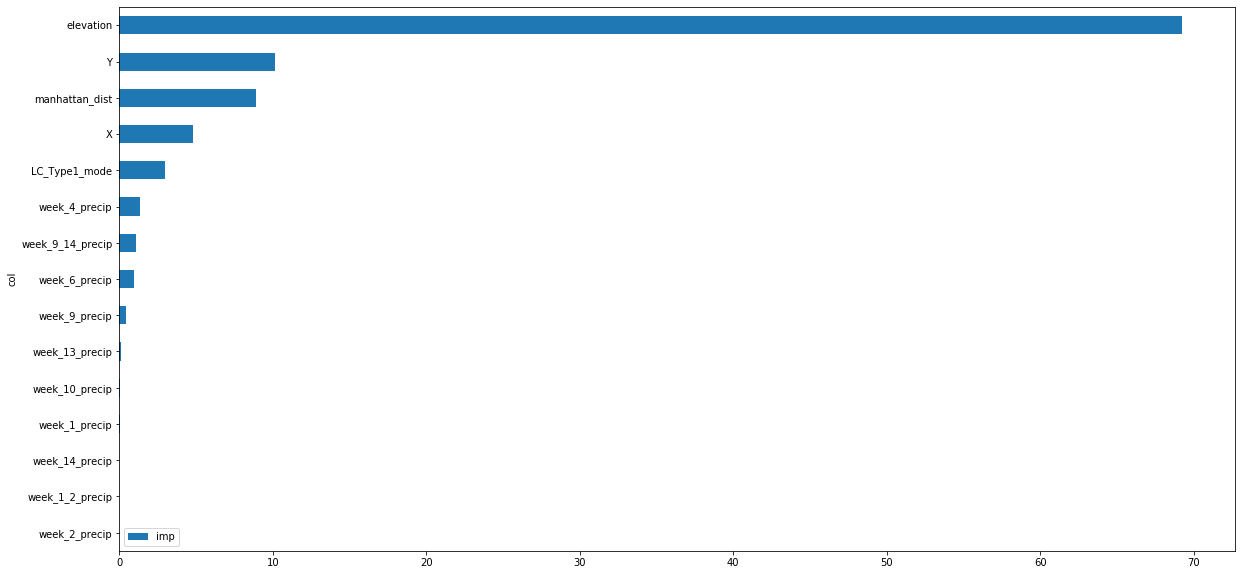

In [32]:
## Check for the feature importance 
fea_imp = pd.DataFrame({'imp':m2.feature_importances_, 'col': test.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')